In [7]:
import torch
from PIL import Image
import io
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import random
import cv2
from PIL import ImageDraw
from math import ceil, floor
from statistics import median
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset

In [8]:
dataset = load_dataset("jonathan-roberts1/Brazilian_Cerrado-Savanna_Scenes")

Found cached dataset parquet (/home/beto_/.cache/huggingface/datasets/jonathan-roberts1___parquet/jonathan-roberts1--Brazilian_Cerrado-Savanna_Scenes-519496fe665653ae/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
class RGB:
  def __init__(self, r, g, b):
    self.r = 255 if r > 255 else (0 if r < 0 else int(r))
    self.g = 255 if g > 255 else (0 if g < 0 else int(g))
    self.b = 255 if b > 255 else (0 if b < 0 else int(b))

In [10]:
class HSB:
  def __init__(self, h, s, b):
    self.h = 360 if h > 360 else (0 if h < 0 else h)
    self.s = 1 if s > 1 else (0 if s < 0 else s)
    self.b = 1 if b > 1 else (0 if b < 0 else b)

In [11]:
def RGB_HSB(rgb: RGB):
  # normalize red, green, and blue values
  r = rgb.r / 255.0
  g = rgb.g / 255.0
  b = rgb.b / 255.0

  max_val = max(r, g, b)
  min_val = min(r, g, b)

  if max_val == min_val:
    h = 0
  elif max_val == r and g >= b:
    h = 60*(g - b)/(max_val - min_val)
  elif max_val == r and g < b:
    h = 60*(g - b)/(max_val - min_val) + 360
  elif max_val == g:
    h = 60*(b - r)/(max_val - min_val) + 120
  elif max_val == b:
    h = 60*(r - g)/(max_val - min_val) + 240

  s = 0 if max_val == 0 else 1.0 - min_val / max_val

  return HSB(h, s, max_val)

In [12]:
def HSB_RGB(hsb: HSB):
  r = 0
  g = 0
  b = 0

  if hsb.s == 0:
    r = g = b = hsb.b
  else:
    sector_pos = hsb.h/60.0
    sector_number = int(sector_pos)
    fractional_sector = sector_pos - sector_number

    p = hsb.b*(1.0 - hsb.s)
    q = hsb.b*(1.0 - (hsb.s*fractional_sector))
    t = hsb.b*(1.0 - (hsb.s*(1 - fractional_sector)))

    if sector_number == 0 or sector_number == 6:
      r = hsb.b
      g = t
      b = p
    elif sector_number == 1:
      r = q
      g = hsb.b
      b = p
    elif sector_number == 2:
      r = p
      g = hsb.b
      b = t
    elif sector_number == 3:
      r = p
      g = q
      b = hsb.b
    elif sector_number == 4:
      r = t
      g = p
      b = hsb.b
    elif sector_number == 5:
      r = hsb.b
      g = p
      b = q

  return RGB(
    int(r*255.0 + 0.5),
    int(g*255.0 + 0.5),
    int(b*255.0 + 0.5)
  )

In [13]:
def get_HSB_pixels(image: Image):
  hsb_pixels = []
  for pixel in image.getdata():
    hsb = RGB_HSB(RGB(pixel[0], pixel[1], pixel[2]))
    hsb_pixels.append((hsb.h, hsb.s, hsb.b))

  return hsb_pixels

In [14]:
def mult_filter_b(image, factor):
  hsb_pixels = get_HSB_pixels(image)

  rgb_pixels = []
  for pixel in hsb_pixels:
    rgb = HSB_RGB(HSB(pixel[0], pixel[1], factor*pixel[2]))
    rgb_pixels.append((rgb.r, rgb.g, rgb.b))

  # Create and save a new image with RGB pixels
  rgb_image = Image.new('RGB', image.size)
  rgb_image.putdata(rgb_pixels)
  return rgb_image

In [15]:
def expand_histogram(image: Image, L):
  min_val_r = 255
  min_val_g = 255
  min_val_b = 255
  max_val_r = 0
  max_val_g = 0
  max_val_b = 0
  for pixel in image.getdata():
    if pixel[0] < min_val_r:
      min_val_r = pixel[0]
    if pixel[1] < min_val_g:
      min_val_g = pixel[1]
    if pixel[2] < min_val_b:
      min_val_b = pixel[2]
    if pixel[0] > max_val_r:
      max_val_r = pixel[0]
    if pixel[1] > max_val_g:
      max_val_g = pixel[1]
    if pixel[2] > max_val_b:
      max_val_b = pixel[2]

  expanded_pixels = []
  for pixel in image.getdata():
    if min_val_r != max_val_r:
      r = int((pixel[0] - min_val_r)/(max_val_r - min_val_r)*(L - 1) + 0.5)
    else:
      r = pixel[0]
    if min_val_g != max_val_g:
      g = int((pixel[1] - min_val_g)/(max_val_g - min_val_g)*(L - 1) + 0.5)
    else:
      g = pixel[1]
    if min_val_b != max_val_b:
      b = int((pixel[2] - min_val_b)/(max_val_b - min_val_b)*(L - 1) + 0.5)
    else:
      b = pixel[2]
    rgb = RGB(r, g, b)
    expanded_pixels.append((rgb.r, rgb.g, rgb.b))

  # Create and save a new image with RGB pixels
  expanded_image = Image.new('RGB', image.size)
  expanded_image.putdata(expanded_pixels)
  return expanded_image

In [16]:
def data_augmentation(dataset):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(dataset['image'], dataset['label']):
        # Converte a imagem para formato numpy
        image_array = np.array(image)

        # Aplica o flip horizontal
        image_flip_horizontal = cv2.flip(image_array, 1)
        augmented_images.append(Image.fromarray(image_flip_horizontal))
        augmented_labels.append(label)

        # Aplica o flip vertical
        image_flip_vertical = cv2.flip(image_array, 0)
        augmented_images.append(Image.fromarray(image_flip_vertical))
        augmented_labels.append(label)

        # Rotação 90°
        image_rotated_90 = image.rotate(90)
        augmented_images.append(image_rotated_90)
        augmented_labels.append(label)

        # Rotação 180°
        image_rotated_180 = image.rotate(180)
        augmented_images.append(image_rotated_180)
        augmented_labels.append(label)

        # Rotação 270°
        image_rotated_270 = image.rotate(270)
        augmented_images.append(image_rotated_270)
        augmented_labels.append(label)

        # Random erasing
        image_random_erased = image.copy()
        draw = ImageDraw.Draw(image_random_erased)

        tamanho_quadrado = 10
        largura, altura = image_random_erased.size


        x1 = random.randint(0, largura - tamanho_quadrado)
        y1 = random.randint(0, altura - tamanho_quadrado)

        x2 = x1 + tamanho_quadrado
        y2 = y1 + tamanho_quadrado

        draw.rectangle([x1, y1, x2, y2], fill = "black")
        augmented_images.append(image_random_erased)
        augmented_labels.append(label)

    augmented_dataset = {'image': augmented_images, 'label': augmented_labels}
    return augmented_dataset

In [17]:
def median_filter(image: Image, m=3, n=3):
  image_c, image_r = image.size

  # Consider the matrix shape for iterating through pixels
  # Choose pivot position: for odd values of length, select the center position;
  #   for even values of length, select the position at the left of the center
  pivot_i = ceil(m/2) - 1
  pivot_j = ceil(n/2) - 1
  start_i = pivot_i
  stop_i = image_r - floor(m/2)
  start_j = pivot_j
  stop_j = image_c - floor(n/2)
  start_delta_i = -pivot_i
  stop_delta_i = floor(m/2) + 1
  start_delta_j = -pivot_j
  stop_delta_j = floor(n/2) + 1

  median_pixels = []
  for i in range(start_i, stop_i):
    for j in range(start_j, stop_j):
      r_vals = []
      g_vals = []
      b_vals = []
      for di in range(start_delta_i, stop_delta_i):
        for dj in range(start_delta_j, stop_delta_j):
          r_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][0])
          g_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][1])
          b_vals.append(image.getdata()[(i + di)*image_c + (j + dj)][2])
      rgb = RGB(median(r_vals), median(g_vals), median(b_vals))
      median_pixels.append((rgb.r, rgb.g, rgb.b))

  median_image = Image.new('RGB', (stop_j - start_j, stop_i - start_i))
  median_image.putdata(median_pixels)
  return median_image

In [18]:
image = dataset['train']['image'][10]
image_bright = mult_filter_b(image, 1.5)
image_expanded = expand_histogram(image, 255)
image_median = median_filter(image)

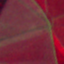

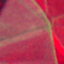

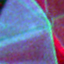

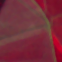

In [19]:
display(image)
display(image_bright)
display(image_expanded)
display(image_median)

In [20]:
image_datasets = []
dataset_names = []
for apply_brightness in [True, False]:
  for apply_expansion in [True, False]:
    for apply_median in [True, False]:
      print('checking')
      new_dataset = dataset['train']['image'].copy()
      if apply_brightness == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = mult_filter_b(new_dataset[i], 1.5)
      if apply_expansion == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = expand_histogram(new_dataset[i], 255)
      if apply_median == True:
        for i in range(len(new_dataset)):
          new_dataset[i] = median_filter(new_dataset[i])
      image_datasets.append(new_dataset)
      dataset_names.append(f'bright-{apply_brightness},expansion-{apply_expansion},median-{apply_median}')

checking


checking
checking
checking
checking
checking
checking
checking


In [21]:
len(image_datasets[0])

1311

In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, label_list, transform=None):
        self.image_list = image_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.label_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNets are typically pre-trained on 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#train_dataset = CustomDataset(image_datasets[7],dataset['train']['label'],transform)

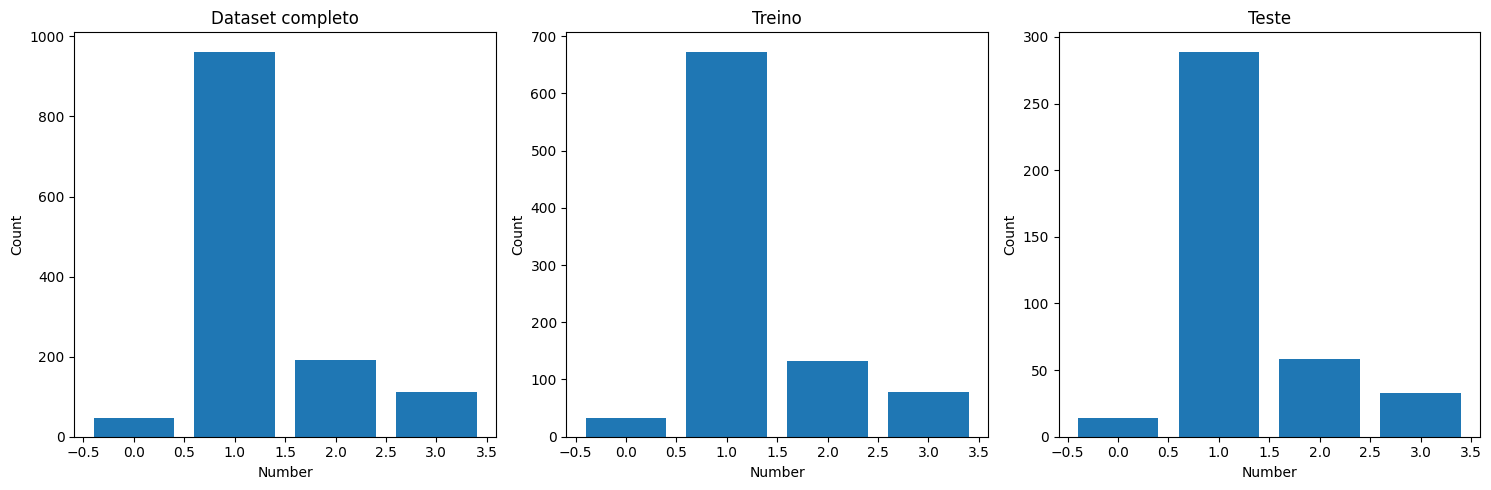

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Function to count the occurrences of each unique number in an array
def count_occurrences(arr):
    return dict(Counter(arr))

# Count occurrences for each array
counts1 = count_occurrences(dataset['train']['label'])
counts2 = count_occurrences(y_train)
counts3 = count_occurrences(y_test)

# Sort the counts by the number
sorted_counts1 = dict(sorted(counts1.items()))
sorted_counts2 = dict(sorted(counts2.items()))
sorted_counts3 = dict(sorted(counts3.items()))

# Plotting bar graphs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for subplots

# Plot for array 1
axs[0].bar(sorted_counts1.keys(), sorted_counts1.values())
axs[0].set_title('Dataset completo')
axs[0].set_xlabel('Number')
axs[0].set_ylabel('Count')

# Plot for array 2
axs[1].bar(sorted_counts2.keys(), sorted_counts2.values())
axs[1].set_title('Treino')
axs[1].set_xlabel('Number')
axs[1].set_ylabel('Count')

# Plot for array 3
axs[2].bar(sorted_counts3.keys(), sorted_counts3.values())
axs[2].set_title('Teste')
axs[2].set_xlabel('Number')
axs[2].set_ylabel('Count')

# Adjust the subplot layout
plt.tight_layout()

# Show all plots
plt.show()

In [35]:
# Fine-tuning the convnet
def finetune_model(model, train_loader, val_loader, num_epochs, device):
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Learning rate scheduler (optional)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

        # Step the scheduler
        scheduler.step()

        # Validation after each epoch
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f'Validation Accuracy: {accuracy:.4f}')

    # Save the fine-tuned model
    torch.save(model.state_dict(), 'fine_tuned_model.pth')

In [38]:
for i in range(6,8):
    
    x_train, x_test, y_train, y_test = train_test_split(image_datasets[i], dataset['train']['label'], test_size=0.3, random_state=42, stratify=dataset['train']['label'])
    train_dataset = {'image': x_train, 'label': y_train}
    test_dataset = {'image': x_test, 'label': y_test}
    train_dataset = data_augmentation(train_dataset)

    train_dataset_torched = CustomDataset(train_dataset['image'],train_dataset['label'],transform)
    test_dataset_torched = CustomDataset(test_dataset['image'],test_dataset['label'],transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset_torched, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(test_dataset_torched, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = models.efficientnet_b0(pretrained=True)

    # Freeze the feature extractor part of the network (optional)
    # for param in model.features.parameters():
    #     param.requires_grad = False

    # Replace the classifier
    num_classes = 4  # replace with your actual number of classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 20  # Number of epochs for training

    print('------------------------')
    print(dataset_names[i])
    finetune_model(model, train_loader, val_loader, num_epochs, device)
    print('------------------------')

------------------------
bright-False,expansion-False,median-True


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Split the dataset into train and validation sets
#train_size = int(0.8 * len(train_dataset))
#val_size = len(train_dataset) - train_size
#train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])